In [1]:
import numpy as np
from pathlib import Path

DATA_DIR = Path.cwd().parent / 'data'

sessions = np.array([])
for file in sorted(DATA_DIR.glob("steinmetz_part*.npz")):
    print(f"Loading {file}...")
    session = np.load(DATA_DIR / file, allow_pickle=True)
    sessions = np.hstack((sessions, session['dat']))

with open(DATA_DIR / "selectors.npy", "rb") as f:
    selectors = np.load(f, allow_pickle=True)

Loading /home/jovyan/work/data/steinmetz_part0.npz...
Loading /home/jovyan/work/data/steinmetz_part1.npz...
Loading /home/jovyan/work/data/steinmetz_part2.npz...


In [2]:
for i in range(len(sessions)):
    session = sessions[i]
    sel = selectors[i]
    neuron_count = sum(sel["NEURON_VISUAL"])
    if neuron_count == 0:
        continue
    stim_count = sum(~sel["STIM_RIGHT_NONE"])
    ratio = stim_count / neuron_count
    print(f"Session {i:2d} - {neuron_count:3d} neurons - {stim_count:3d} trials w/ stimulus - {ratio:2.2f} ratio")

Session  0 - 178 neurons - 128 trials w/ stimulus - 0.72 ratio
Session  1 - 533 neurons - 136 trials w/ stimulus - 0.26 ratio
Session  2 - 228 neurons - 119 trials w/ stimulus - 0.52 ratio
Session  3 -  39 neurons - 142 trials w/ stimulus - 3.64 ratio
Session  6 - 101 neurons - 133 trials w/ stimulus - 1.32 ratio
Session  7 -  89 neurons - 148 trials w/ stimulus - 1.66 ratio
Session  8 - 221 neurons - 179 trials w/ stimulus - 0.81 ratio
Session  9 - 204 neurons - 202 trials w/ stimulus - 0.99 ratio
Session 10 - 275 neurons - 169 trials w/ stimulus - 0.61 ratio
Session 11 - 145 neurons - 173 trials w/ stimulus - 1.19 ratio
Session 12 -  66 neurons - 162 trials w/ stimulus - 2.45 ratio
Session 13 -  79 neurons - 140 trials w/ stimulus - 1.77 ratio
Session 16 -  12 neurons - 134 trials w/ stimulus - 11.17 ratio
Session 17 - 158 neurons - 153 trials w/ stimulus - 0.97 ratio
Session 18 - 179 neurons - 130 trials w/ stimulus - 0.73 ratio
Session 19 - 122 neurons - 149 trials w/ stimulus - 1.

In [3]:
DECODER_SESSION = 21
SESSION = sessions[DECODER_SESSION]
SELECTOR = selectors[DECODER_SESSION]

CHOSEN_TRIALS = ~SELECTOR["STIM_RIGHT_NONE"]
TIMES_VISION = np.arange(42, 158)

CLASS_NAMES = ["Low", "Medium", "High"]
NUM_CLASSES = len(CLASS_NAMES)

In [4]:
num_no_stim = CHOSEN_TRIALS.sum() // 3
no_stim_trials = ~CHOSEN_TRIALS
cutoff_index = np.where(no_stim_trials.cumsum() > num_no_stim)[0][0]
no_stim_trials[cutoff_index:] = False

CHOSEN_TRIALS |= no_stim_trials
CLASS_NAMES.insert(0, "None")
NUM_CLASSES += 1

In [5]:
from scipy import signal

def get_spikes_and_contrast(session, neurons, trials, bins, baseline_bins=None, smoothing=None):
    spikes = session['spks'][neurons][:, trials][:, :, bins]
    
    if baseline_bins is not None:
        start, end = baseline_bins
        baseline = session['spks'][neurons][:, trials][:, :, start:end]
        baseline = baseline.mean(axis=2)[:, :, np.newaxis]
        spikes = (spikes - baseline) / (baseline + 0.5)
        
    if smoothing is not None:
        size, std = smoothing
        half_gaussian = signal.gaussian(size, std)
        half_gaussian[size//2 + 1:] = 0
        spikes = signal.convolve(spikes, half_gaussian[np.newaxis, np.newaxis, :], mode='valid')
        
    return spikes, session['contrast_right'][trials]

def reshape_by_bins(spikes):
    return spikes.transpose((1, 2, 0)).reshape(spikes.shape[1] * spikes.shape[2], spikes.shape[0])

In [6]:
from sklearn.preprocessing import LabelEncoder

spikes, contrast = get_spikes_and_contrast(
    SESSION,
    SELECTOR["NEURON_VISUAL"],
    CHOSEN_TRIALS,
    TIMES_VISION,
    baseline_bins=(30,50),
    smoothing=(17, 2.5),
)
NUM_BINS = spikes.shape[2]

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(np.repeat(contrast, NUM_BINS))
X = reshape_by_bins(spikes)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(penalty='l2', multi_class='ovr', solver='saga', max_iter=5000)
scores = cross_val_score(clf, X, Y, cv=5)
print(scores)
print(scores.mean())

clf.fit(X, Y)

[0.40141844 0.4108156  0.41241135 0.37978723 0.41276596]
0.4034397163120567


LogisticRegression(max_iter=5000, multi_class='ovr', solver='saga')

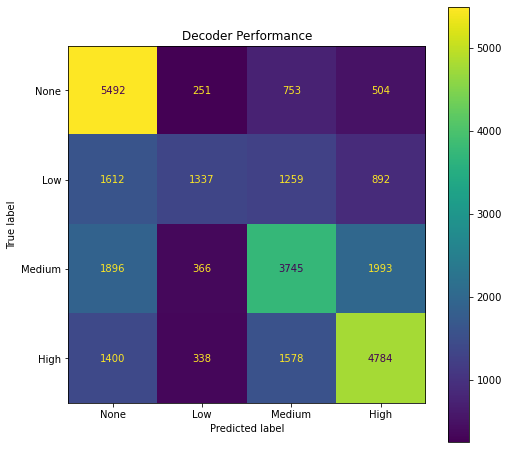

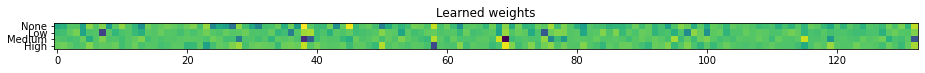

In [8]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

disp = plot_confusion_matrix(clf, X, Y, display_labels=CLASS_NAMES)
disp.ax_.set_title("Decoder Performance")
disp.figure_.set_size_inches(8, 8)
plt.show()

weights = clf.coef_
fig, ax = plt.subplots()
im = ax.imshow(weights)

ax.set_yticks(np.arange(weights.shape[0]))
ax.set_yticklabels(CLASS_NAMES)

ax.set_title("Learned weights")
fig.set_size_inches(12, 10)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.show()

In [9]:
def get_trial_performance(selector):
    '''
    Calculate behavioral performance
    
    Arguments:
    selector -- selectors for a single trial
    
    Return:
    performance -- np.array of average accuracy per contrast level
    '''
    return np.array([
        [selector['CHOICE_CORRECT'][selector["STIM_RIGHT_NONE"]].mean(), selector["STIM_RIGHT_NONE"].sum()],
        [selector['CHOICE_CORRECT'][selector["STIM_RIGHT_LOW"]].mean(), selector["STIM_RIGHT_LOW"].sum()],
        [selector['CHOICE_CORRECT'][selector["STIM_RIGHT_MEDIUM"]].mean(), selector["STIM_RIGHT_MEDIUM"].sum()],
        [selector['CHOICE_CORRECT'][selector["STIM_RIGHT_HIGH"]].mean(), selector["STIM_RIGHT_HIGH"].sum()],
    ])

behavior = get_trial_performance(SELECTOR)

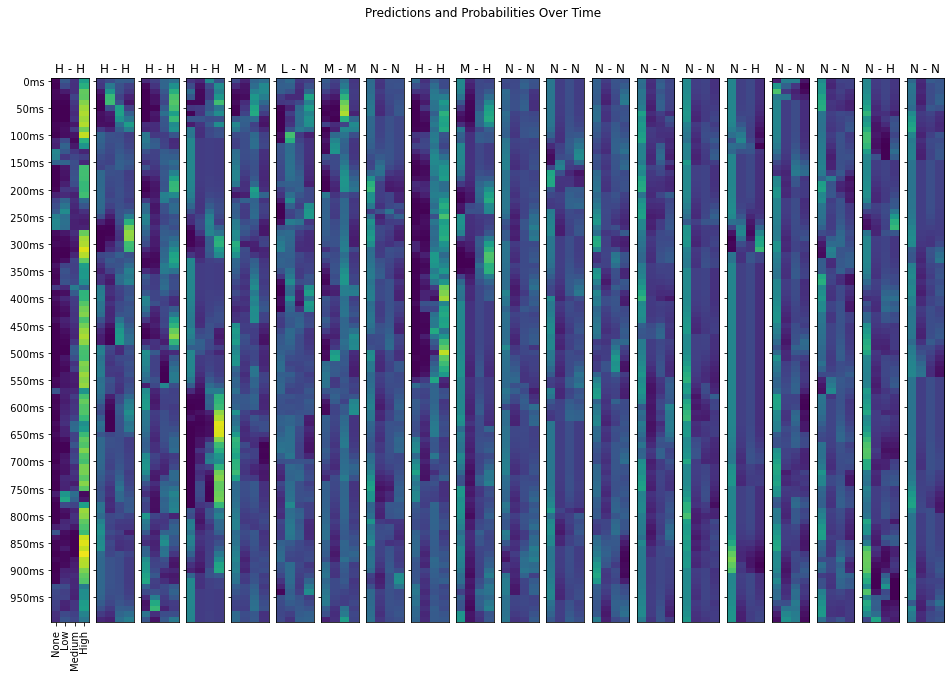

In [10]:
plotted_trials = 20
yticks = np.arange(NUM_BINS // 5) * 5
yticklabels = [f"{i*10:4d}ms" for i in yticks]
fig, axes = plt.subplots(1, plotted_trials, sharey=True)
fig.set_size_inches(16, 10)

confusion_matrices = np.zeros((2, NUM_CLASSES, NUM_CLASSES), dtype=int)
mouse_correct = SELECTOR["CHOICE_CORRECT"][CHOSEN_TRIALS].astype(int)

for trial_num in range(spikes.shape[1]):
    correct_class = label_encoder.transform(contrast[[trial_num]])[0]
    population_activity = X[(trial_num*NUM_BINS):((trial_num+1)*NUM_BINS), :]
    probs = clf.predict_proba(population_activity)
    
    prediction = 0
    predict_times = np.argmax(probs[:, 1:] >= behavior[1:, 0], axis=0)
    if np.any(predict_times > 0):
        prediction = NUM_CLASSES - np.argmax(predict_times[::-1] > 0) - 1

    confusion_matrices[mouse_correct[trial_num], correct_class, prediction] += 1
    
    if trial_num >= plotted_trials:
        continue

    ax = axes[trial_num]
    im = ax.imshow(probs, vmin=0, vmax=1, aspect='auto')
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_title(f"{CLASS_NAMES[correct_class][0]} - {CLASS_NAMES[prediction][0]}")
    
    if trial_num != 0:
        ax.set_xticks([])
        continue

    ax.set_xticks(np.arange(NUM_CLASSES))
    ax.set_xticklabels(CLASS_NAMES)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", va="center", rotation_mode="anchor")

fig.suptitle("Predictions and Probabilities Over Time")
plt.show()

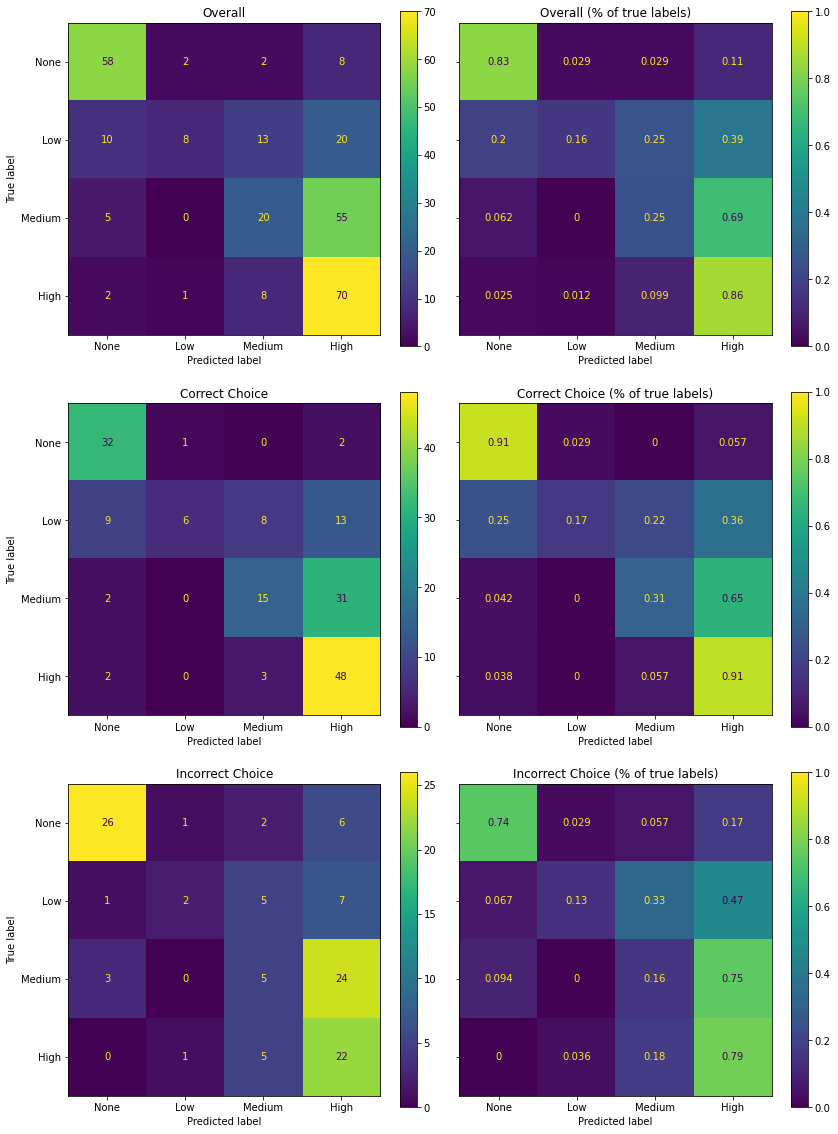

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(3, 2)
fig.set_size_inches(12, 16)
fig.set_tight_layout(True)

data = [
    (confusion_matrices.sum(axis=0), "Overall"),
    (confusion_matrices[1], "Correct Choice"),
    (confusion_matrices[0], "Incorrect Choice"),
]
for i, (perf, title) in enumerate(data):
    axes[i, 0].set_title(title)
    ConfusionMatrixDisplay(perf, display_labels=CLASS_NAMES).plot(ax=axes[i, 0])
    
    ax = axes[i, 1]
    perf = perf / perf.sum(axis=1, keepdims=True)
    disp = ConfusionMatrixDisplay(perf, display_labels=CLASS_NAMES).plot(ax=ax)
    disp.im_.colorbar.remove()
    disp.im_ = ax.imshow(perf, vmin=0, vmax=1)
    fig.colorbar(disp.im_, ax=ax)
    ax.set_title(f"{title} (% of true labels)")
    ax.set_ylabel("")
    ax.set_yticklabels([])

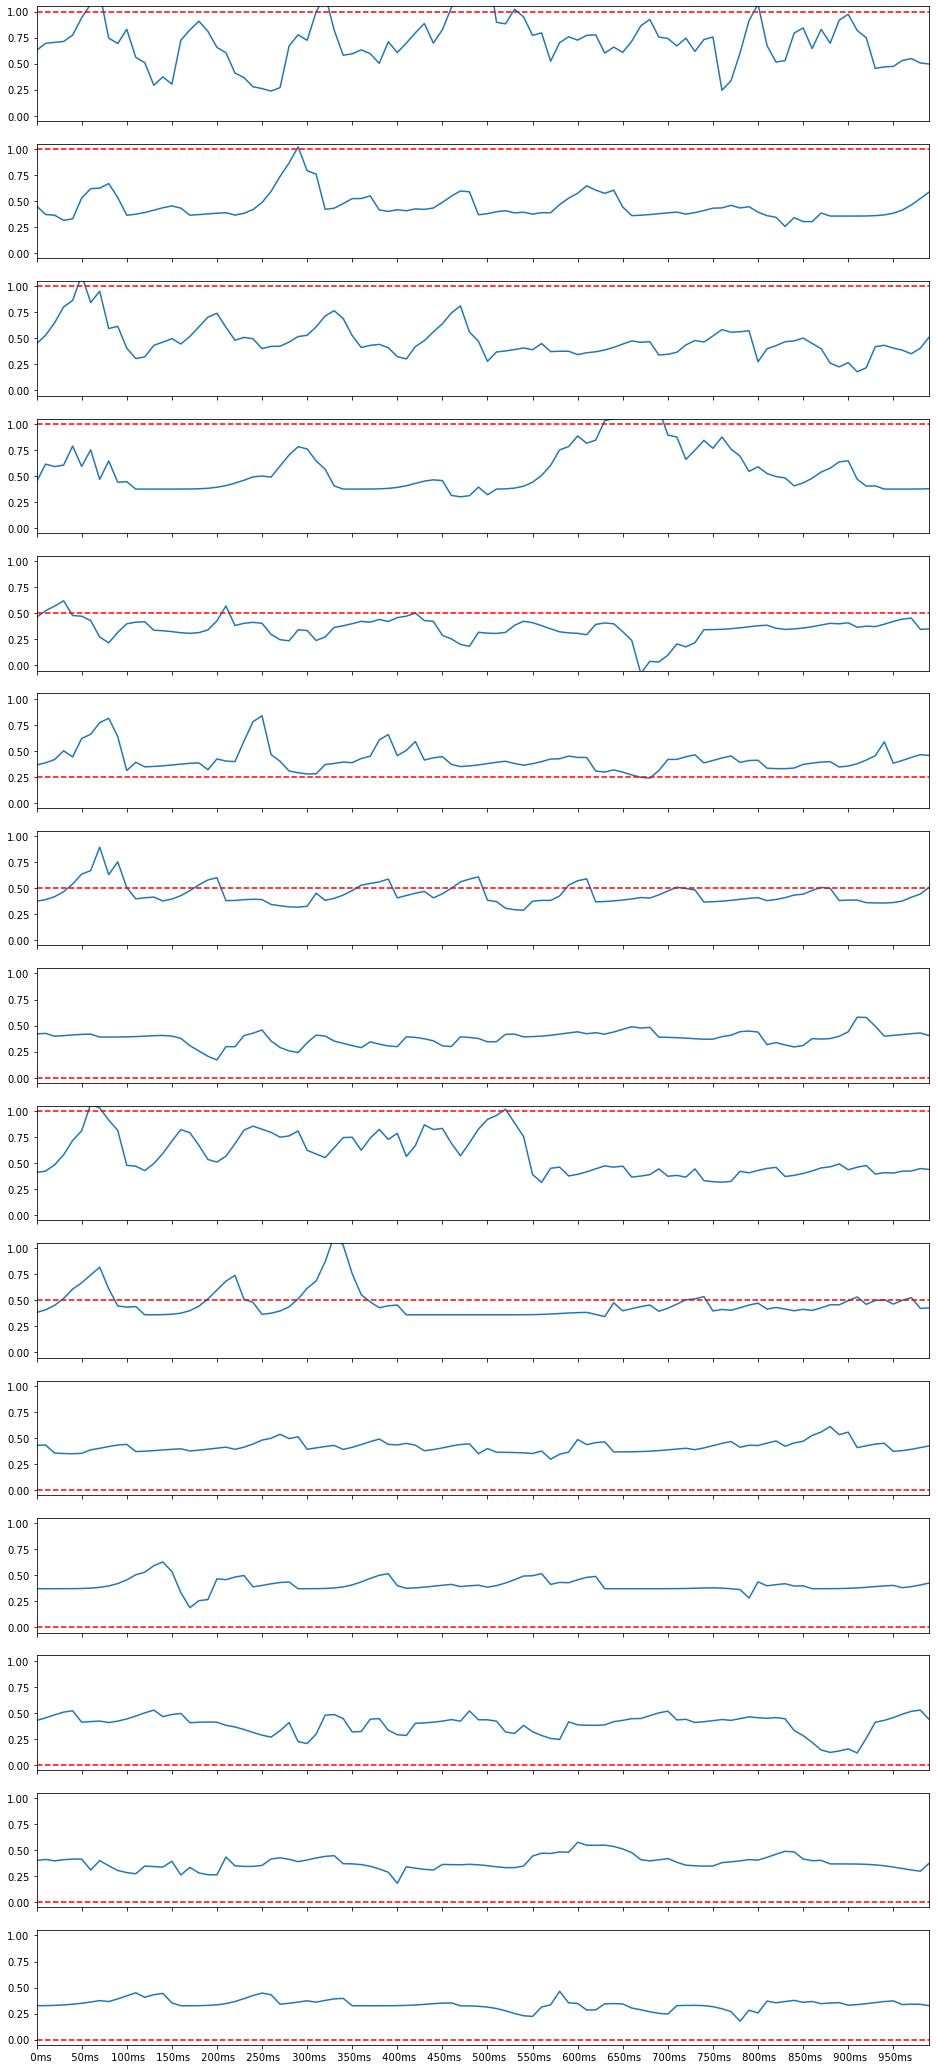

In [13]:
from sklearn.linear_model import Ridge

Y_reg = label_encoder.inverse_transform(Y)
reg = Ridge()
reg.fit(X, Y_reg)

plotted_trials = 15
xticks = np.arange(NUM_BINS // 5) * 5
xticklabels = [f"{i*10:4d}ms" for i in yticks]
fig, axes = plt.subplots(plotted_trials, 1, sharex=True)
fig.set_size_inches(16, 2.5 * plotted_trials)

for trial_num in range(plotted_trials):
    Y_true = contrast[trial_num]
    population_activity = X[(trial_num*NUM_BINS):((trial_num+1)*NUM_BINS), :]
    Y_pred = reg.predict(population_activity)
    
    ax = axes[trial_num]
    ax.plot(Y_pred)
    ax.set_ylim([-0.05, 1.05])
    ax.axhline(y=Y_true, color='r', linestyle='--')
    
    if trial_num != plotted_trials - 1:
        continue

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim([0, NUM_BINS - 1])

plt.show()